<a href="https://colab.research.google.com/github/AnirbanMukherjeeXD/human-activity-recognition/blob/master/HAR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle API dataset

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d erenaktas/human-activity-recognition --unzip

 90% 107M/119M [00:02<00:00, 42.8MB/s] 
100% 119M/119M [00:02<00:00, 57.7MB/s]


## Importing libraries

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean
from numpy import std
from numpy import dstack
from sklearn.metrics import confusion_matrix

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,Conv1D, SeparableConv1D, MaxPooling1D
from tensorflow import feature_column
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

## Dataset Loading

In [0]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	print("Loading: ",filepath)
	return dataframe.values

In [0]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [0]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

In [0]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'UCI_HAR_Dataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'UCI_HAR_Dataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [0]:
X_train, Y_train, X_test, Y_test = load_dataset()

Loading:  UCI_HAR_Dataset/train/Inertial Signals/total_acc_x_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/total_acc_y_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/total_acc_z_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_acc_x_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_acc_y_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_acc_z_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_gyro_x_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_gyro_y_train.txt
Loading:  UCI_HAR_Dataset/train/Inertial Signals/body_gyro_z_train.txt
Loading:  UCI_HAR_Dataset/train/y_train.txt
(7352, 128, 9) (7352, 1)
Loading:  UCI_HAR_Dataset/test/Inertial Signals/total_acc_x_test.txt
Loading:  UCI_HAR_Dataset/test/Inertial Signals/total_acc_y_test.txt
Loading:  UCI_HAR_Dataset/test/Inertial Signals/total_acc_z_test.txt
Loading:  UCI_HAR_Dataset/test/Inertial Signals/body_acc_x_test.txt
Loading:  UCI_HAR_Da

In [0]:
X_train.shape

(7352, 128, 9)

In [0]:
Y_train.shape

(7352, 6)

In [0]:
X_train[0,:,0].shape

(128,)

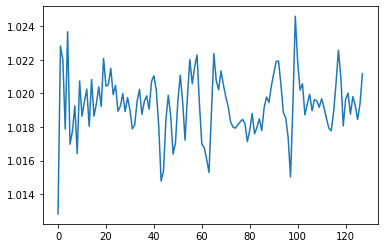

In [0]:
plt.plot(X_train[0,:,0])

## Model 1: Simple CNN

In [0]:
model=load_model('regular-cnn.h5')

In [0]:
verbose, epochs, batch_size = 2, 10, 32

In [0]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

In [0]:
print(n_timesteps, n_features, n_outputs)

128 9 6


In [0]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=11, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=9, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 118, 64)           6400      
_________________________________________________________________
dropout_9 (Dropout)          (None, 118, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 108, 64)           45120     
_________________________________________________________________
dropout_10 (Dropout)         (None, 108, 64)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 100, 64)           36928     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 50, 64)           

In [0]:
regular_cnn_params=model.count_params()

In [0]:
history=model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, verbose=verbose)

Train on 7352 samples
Epoch 1/100
7352/7352 - 2s - loss: 0.4441 - accuracy: 0.8244
Epoch 2/100
7352/7352 - 1s - loss: 0.1402 - accuracy: 0.9422
Epoch 3/100
7352/7352 - 1s - loss: 0.1404 - accuracy: 0.9482
Epoch 4/100
7352/7352 - 1s - loss: 0.1120 - accuracy: 0.9504
Epoch 5/100
7352/7352 - 1s - loss: 0.1225 - accuracy: 0.9513
Epoch 6/100
7352/7352 - 1s - loss: 0.1189 - accuracy: 0.9479
Epoch 7/100
7352/7352 - 1s - loss: 0.1011 - accuracy: 0.9550
Epoch 8/100
7352/7352 - 1s - loss: 0.0949 - accuracy: 0.9559
Epoch 9/100
7352/7352 - 1s - loss: 0.0891 - accuracy: 0.9565
Epoch 10/100
7352/7352 - 1s - loss: 0.0813 - accuracy: 0.9631
Epoch 11/100
7352/7352 - 1s - loss: 0.0834 - accuracy: 0.9599
Epoch 12/100
7352/7352 - 1s - loss: 0.0929 - accuracy: 0.9581
Epoch 13/100
7352/7352 - 1s - loss: 0.1035 - accuracy: 0.9582
Epoch 14/100
7352/7352 - 1s - loss: 0.0761 - accuracy: 0.9644
Epoch 15/100
7352/7352 - 1s - loss: 0.0780 - accuracy: 0.9656
Epoch 16/100
7352/7352 - 1s - loss: 0.0721 - accuracy: 0.

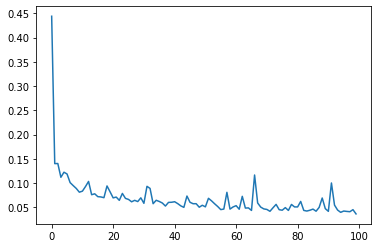

In [0]:
plt.plot(history.history['loss'])

In [0]:
regular_cnn_acc_train=model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=0)[1]
regular_cnn_acc_test=model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)[1]
print("Training set: ",regular_cnn_acc_train*100,"%")
print("Test set: ",regular_cnn_acc_test*100,"%")

Training set:  98.13656210899353 %
Test set:  90.87207317352295 %


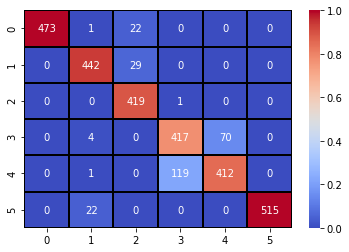

In [0]:
Y_pred=model.predict(X_test)
cm=confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
sns.heatmap(cm/cm.sum(axis=0),cmap='coolwarm',annot=cm,fmt='g',linewidths=1, linecolor='black')

In [0]:
model.save('regular-cnn.h5')

## Model 2: Separable CNN

In [0]:
model=load_model('separable-cnn.h5')

In [0]:
verbose, epochs, batch_size = 2, 10, 32

In [0]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]

In [0]:
print(n_timesteps, n_features, n_outputs)

128 9 6


In [0]:
model = Sequential()
model.add(SeparableConv1D(filters=64, kernel_size=11, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(SeparableConv1D(filters=64, kernel_size=11, activation='relu'))
model.add(Dropout(0.5))
model.add(SeparableConv1D(filters=64, kernel_size=9, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv1d_59 (Separab (None, 118, 64)           739       
_________________________________________________________________
dropout_37 (Dropout)         (None, 118, 64)           0         
_________________________________________________________________
separable_conv1d_60 (Separab (None, 108, 64)           4864      
_________________________________________________________________
dropout_38 (Dropout)         (None, 108, 64)           0         
_________________________________________________________________
separable_conv1d_61 (Separab (None, 100, 64)           4736      
_________________________________________________________________
dropout_39 (Dropout)         (None, 100, 64)           0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 50, 64)          

In [0]:
separable_cnn_params=model.count_params()

In [0]:
history=model.fit(X_train, Y_train, epochs=100, batch_size=batch_size, verbose=verbose)

Train on 7352 samples
Epoch 1/100
7352/7352 - 2s - loss: 0.7292 - accuracy: 0.7091
Epoch 2/100
7352/7352 - 1s - loss: 0.1882 - accuracy: 0.9245
Epoch 3/100
7352/7352 - 1s - loss: 0.1317 - accuracy: 0.9445
Epoch 4/100
7352/7352 - 1s - loss: 0.1436 - accuracy: 0.9431
Epoch 5/100
7352/7352 - 1s - loss: 0.1150 - accuracy: 0.9504
Epoch 6/100
7352/7352 - 1s - loss: 0.1127 - accuracy: 0.9505
Epoch 7/100
7352/7352 - 1s - loss: 0.1124 - accuracy: 0.9512
Epoch 8/100
7352/7352 - 1s - loss: 0.1124 - accuracy: 0.9508
Epoch 9/100
7352/7352 - 1s - loss: 0.1032 - accuracy: 0.9559
Epoch 10/100
7352/7352 - 1s - loss: 0.0962 - accuracy: 0.9573
Epoch 11/100
7352/7352 - 1s - loss: 0.0970 - accuracy: 0.9574
Epoch 12/100
7352/7352 - 1s - loss: 0.0932 - accuracy: 0.9574
Epoch 13/100
7352/7352 - 1s - loss: 0.0827 - accuracy: 0.9626
Epoch 14/100
7352/7352 - 1s - loss: 0.0794 - accuracy: 0.9623
Epoch 15/100
7352/7352 - 1s - loss: 0.0756 - accuracy: 0.9644
Epoch 16/100
7352/7352 - 1s - loss: 0.0738 - accuracy: 0.

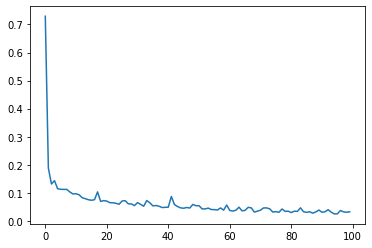

In [0]:
plt.plot(history.history['loss'])

In [0]:
separable_cnn_acc_train=model.evaluate(X_train, Y_train, batch_size=batch_size, verbose=0)[1]
separable_cnn_acc_test=model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)[1]

print("Training set: ",separable_cnn_acc_train*100,"%")
print("Test set: ",separable_cnn_acc_test*100,"%")

Training set:  98.97986650466919 %
Test set:  90.0237500667572 %


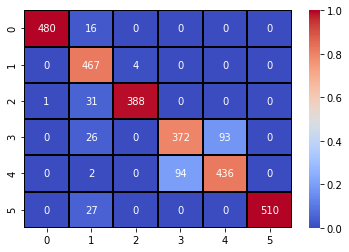

In [0]:
Y_pred=model.predict(X_test)
cm=confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
sns.heatmap(cm/cm.sum(axis=0),cmap='coolwarm',annot=cm,fmt='g',linewidths=1, linecolor='black')

In [0]:
model.save('separable-cnn.h5')

## Comparison

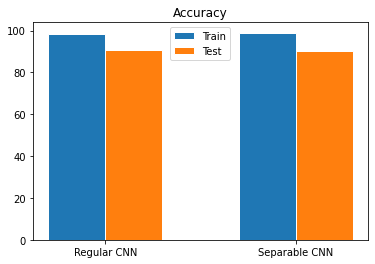

In [0]:
regular_acc=[regular_cnn_acc_train,regular_cnn_acc_test]
separable_acc=[separable_cnn_acc_train,separable_cnn_acc_test]

train=[regular_cnn_acc_train*100,separable_cnn_acc_train*100]
test=[regular_cnn_acc_test*100,separable_cnn_acc_test*100]

barWidth = 0.3
  
# Set position of bar on X axis
r1 = np.arange(len(train))
r2 = [x + barWidth for x in r1]

plt.title("Accuracy")
plt.bar(r1, train,  width=barWidth, edgecolor='white', label='Train')
plt.bar(r2, test, width=barWidth, edgecolor='white', label='Test')
plt.xticks([0.15,1.15],["Regular CNN","Separable CNN"])
plt.legend(loc=9)
plt.show()

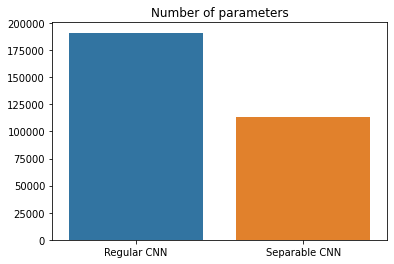

In [0]:
plt.title("Number of parameters")
sns.barplot(["Regular CNN","Separable CNN"],[regular_cnn_params,separable_cnn_params])
plt.show()

In [0]:
plt.title("Number of parameters")
sns.barplot(["Regular CNN","Separable CNN"],[regular_cnn_params,separable_cnn_params])

## Extra

In [0]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [0]:
# run an experiment
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

In [0]:
# run the experiment
run_experiment(1)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
>#1: 90.193
[90.19341468811035]
Accuracy: 90.193% (+/-0.000)


## Mobile Data

In [0]:
mob=pd.read_csv('2.csv')
mob.head()

,id,time,accX,accY,accZ,gyroX,gyroY,gyroZ,linAccX,linAccY,linAccZ,magX,magY,magZ,rot1,rot2,rot3,rot4,rot5,rot6,rot7,rot8,rot9
0,2,1481931708065445,0.59877,1.188060,10.36690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000
1,2,1481931801754410,0.59877,1.188060,10.36690,-0.133881,-0.158142,0.003845,0.000000,0.000000,0.000000,0.0000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000
2,2,1481931921200211,0.59877,1.188060,10.36690,-0.133881,-0.158142,0.003845,0.000000,0.000000,0.000000,21.8781,2.69012,-33.0673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.00000
3,2,1481931999844009,-1.12267,0.899796,9.53133,0.216583,-0.127029,-0.010010,-0.989412,-0.366415,-0.378374,21.8781,2.69012,-33.0673,-0.302774,0.945035,-0.123440,0.359368,-0.006755,-0.933171,-0.882713,-0.3269,-0.33757
4,2,1481932122646744,-1.12267,0.899796,9.53133,0.216583,-0.127029,-0.010010,-0.989412,-0.366415,-0.378374,22.4777,2.24152,-33.6685,-0.297911,0.944858,-0.135986,0.363410,-0.019471,-0.931426,-0.882713,-0.3269,-0.33757


In [0]:
mdata=mob.iloc[:,2:11].values

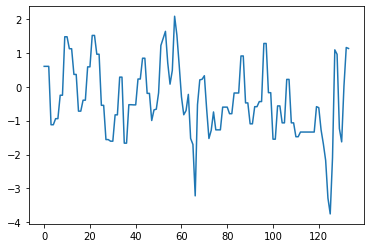

In [0]:
plt.plot(mdata[:,0])